#### Example 1. Random generated data (non-linear-separable)

##### Method 1. Self-built model using numpy

generate random data

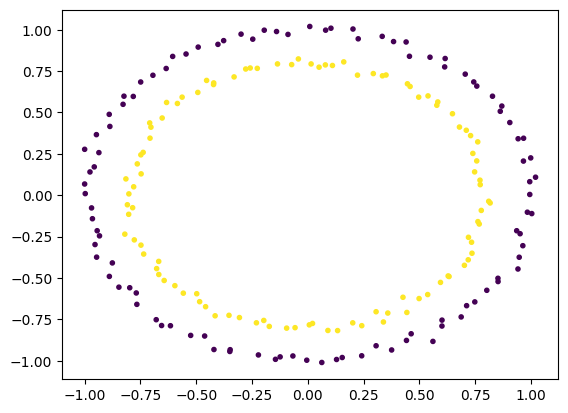

In [95]:
import numpy as np
from numpy import linalg
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

# Generate dataset and targets
X, Y = make_circles(n_samples = 200, noise = 0.02)
# visualizing data
plt.scatter(X[:, 0], X[:, 1], c = Y, marker = '.')
plt.show()

In [80]:
y = np.copy(Y)
y[y == 0] = -1

define different kernel functions (linear, poly, rbf)

In [1]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, gamma = 1, r = 1, d=3):
    return (r + gamma*np.dot(x, y)) ** d

def gaussian_kernel(x, y, sigma=5.0):
    # gamma = 1.0/(2 * (sigma ** 2))
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

define fit and predict function for SVM model

In [70]:
def fit(X, y, kernel=linear_kernel, C=None):
    n_samples, n_features = X.shape
    
    # solve problem as Quadratic Programming
    # define required parameters
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i,j] = kernel(X[i], X[j])

    P = matrix(np.outer(y,y) * K)
    q = matrix(np.ones(n_samples) * -1)
    A = matrix(y, (1,n_samples))
    A = A * 1.0
    b = matrix(0.0)
    
    if C is None:
        G = matrix(np.diag(np.ones(n_samples) * -1))
        h = matrix(np.zeros(n_samples))
    else:
        tmp1 = np.diag(np.ones(n_samples) * -1)
        tmp2 = np.identity(n_samples)
        G = matrix(np.vstack((tmp1, tmp2)))
        tmp1 = np.zeros(n_samples)
        tmp2 = np.ones(n_samples) * C
        h = matrix(np.hstack((tmp1, tmp2)))

    # solve
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    
    # Lagrange multipliers a = \lambda
    a = np.ravel(solution['x'])
    
    # support vectors have non zero lagrange multipliers
    sv = a > 1e-5
    ind = np.arange(len(a))[sv]
    l = a[ind]
    sv_x = X[ind]
    sv_y = y[ind]
    print("%d support vectors out of %d points" % (len(l), n_samples))

    # intercept
    b = 0
    for n in range(len(l)):
        b += sv_y[n]
        b -= np.sum(l * sv_y * K[ind[n], sv])
        b /= len(l)

    # weight vector
    if kernel == linear_kernel:
        w = np.zeros(n_features)
        for n in range(len(l)):
            w += l[n] * sv_y[n] * sv_x[n]
    else:
        w = None
    return w, b, l, sv_x, sv_y

In [83]:
def predict(X, kernel, w, b, l, sv_x, sv_y):
    if w is not None:
        return np.sign(np.dot(X, w) + b)
    else:
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for lam, vec_x, vec_y in zip(l, sv_x, sv_y):
                s += lam * vec_y * kernel(X[i], vec_x)
                y_predict[i] = s
        return np.sign(y_predict + b)

train model and predict

In [84]:
kernel = gaussian_kernel
w, b, l, sv_x, sv_y = fit(X, y, kernel)
pred = predict(X, kernel, w, b, l, sv_x, sv_y)
pred

10 support vectors out of 200 points


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

evaluate

In [85]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(y, pred))
print(confusion_matrix(y, pred))

0.5
[[  0 100]
 [  0 100]]


##### Method 2. sklearn library

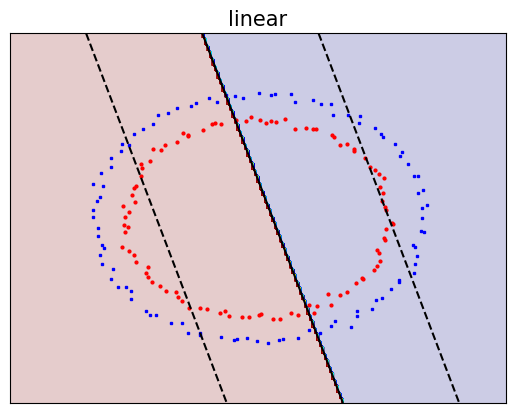

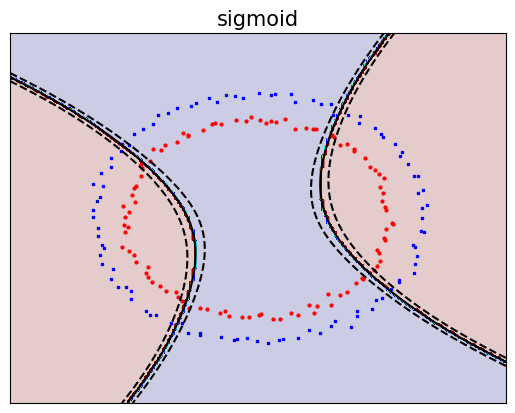

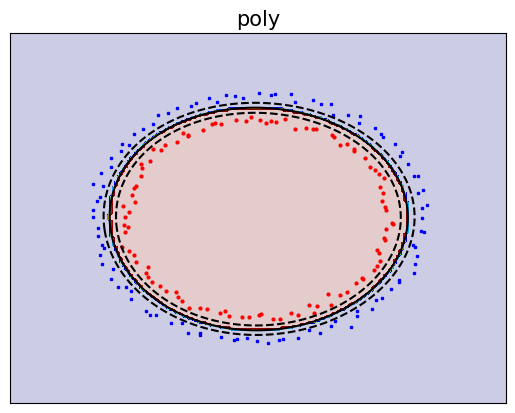

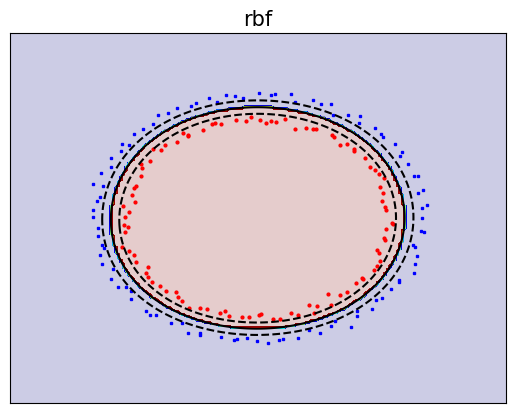

In [96]:
# train model and visualize result
from sklearn.svm import SVC

def svm_model(X, Y):
    fignum = 1

    # fit the model
    for kernel in ('linear','sigmoid', 'poly', 'rbf'):
        clf = SVC(kernel=kernel, gamma=1, coef0 = 1)
        clf.fit(X, Y)

        # plot the line, the points, and the nearest vectors to the plane
        fig, ax = plt.subplots()
        plt.figure(fignum, figsize=(5, 5))
        plt.clf()

        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], 
                    s=80, facecolors='None')
        plt.plot(X[Y==0, 0], X[Y==0, 1], 'bs', markersize = 2)
        plt.plot(X[Y==1, 0], X[Y==1, 1], 'ro', markersize = 2)
        
        plt.axis('tight')
        x_min = -1.5
        x_max = 1.5
        y_min = -1.5
        y_max = 1.5
        
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
        
        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(5, 5))
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], 
                    linestyles=['--', '-', '--'], 
                    levels=[-.5, 0, .5])
        plt.title(kernel, fontsize = 15)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        
        plt.xticks(())
        plt.yticks(())
        fignum = fignum + 1
        # pdf.savefig()
    plt.show()

svm_model(X, Y)

#### Example 2. Microchip Quality Assessment

read data

In [92]:
import pandas as pd

df = pd.read_csv('ex2data2.txt', header=None)
df.head()

,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [107]:
Y = np.array(df[2])
X = np.array(df.drop(2, axis=1))

visualize data

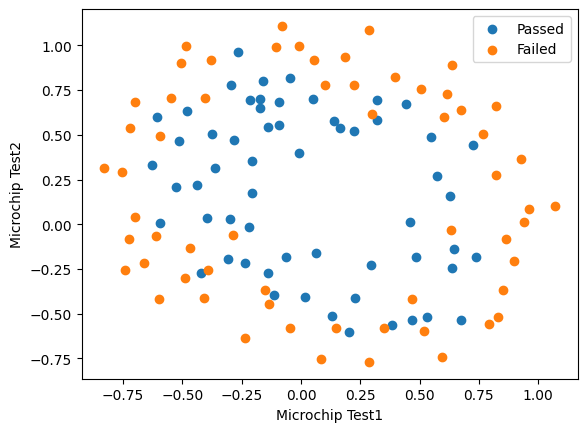

In [108]:
mask = Y == 1
passed = plt.scatter(X[mask][:, 0], X[mask][:, 1])
failed = plt.scatter(X[~mask][:, 0], X[~mask][:,1])
plt.xlabel('Microchip Test1')
plt.ylabel('Microchip Test2')
plt.legend((passed, failed), ('Passed', 'Failed'))
plt.show()

train model and display result

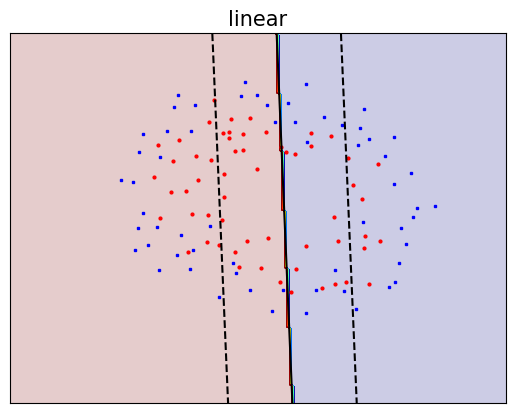

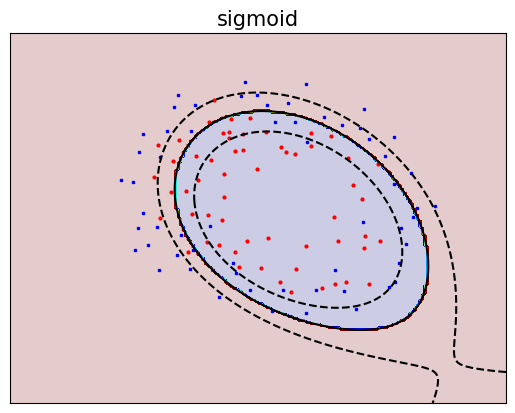

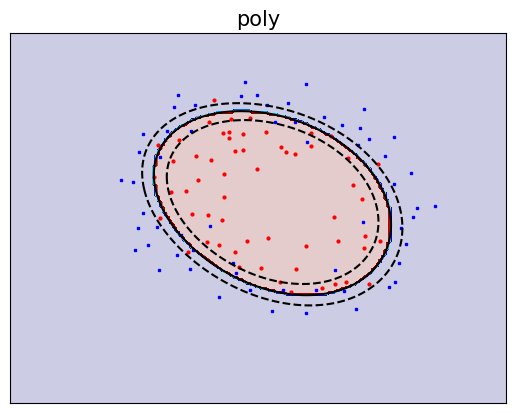

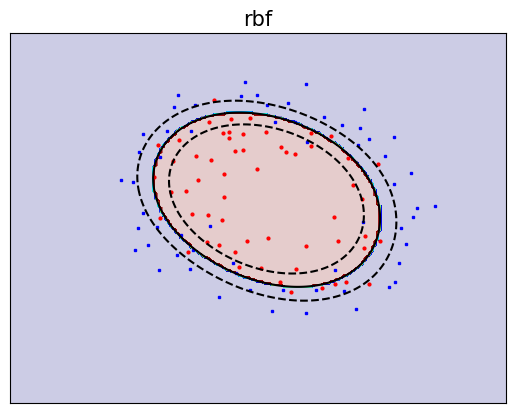

In [109]:
svm_model(X, Y)

#### Exercise 1. ARgender

load data from file

In [110]:
import scipy.io as sio
from sklearn.svm import SVC

A = sio.loadmat('ARgender.mat')
X_train = A['Y_train'].T
X_test = A['Y_test'].T
print(X_train.shape)

(700, 300)


In [112]:
N = 700
y_train = A['label_train'].reshape(N)
y_test = A['label_test'].reshape(N)
print(y_train.shape)

(700,)


train model and evaluate

In [114]:
# fit the model
for kernel in ('linear','sigmoid', 'poly', 'rbf'):
    clf = SVC(kernel=kernel, gamma=1, coef0 = 1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print(f'{kernel} kernel')
    print('accuracy score:', accuracy_score(y_test, pred))
    print('confusion matrix:\n', confusion_matrix(y_test, pred))

linear kernel
accuracy score: 0.9028571428571428
confusion matrix:
 [[344   6]
 [ 62 288]]
sigmoid kernel
accuracy score: 0.8942857142857142
confusion matrix:
 [[342   8]
 [ 66 284]]
poly kernel
accuracy score: 0.9228571428571428
confusion matrix:
 [[330  20]
 [ 34 316]]
rbf kernel
accuracy score: 0.9085714285714286
confusion matrix:
 [[341   9]
 [ 55 295]]


#### Exercise 2. Custom Dataset

read data

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('dataset.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
print(X.shape)
print(y.shape)
dataset.head()

(400, 2)
(400,)


,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


visualize data

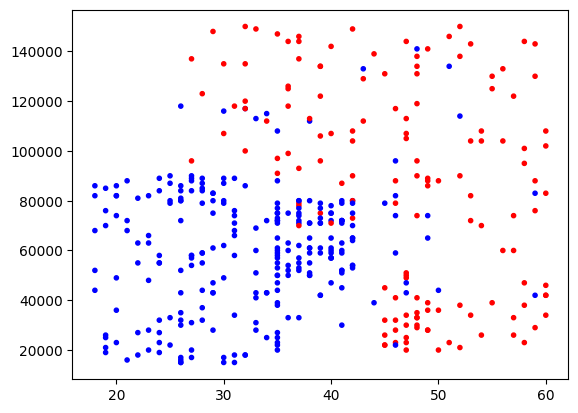

In [142]:
plt.scatter(X[:, 0], X[:, 1], c = y, marker = '.', cmap='bwr')
plt.show()

split and rescale data

In [118]:
# split data into training and test set
from sklearn.model_selection import train_test_split
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.25, random_state = 0)
print(XTrain.shape)
print(XTest.shape)
print(yTrain.shape)
print(yTest.shape)

# rescaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
XTrain = sc.fit_transform(XTrain)
XTest = sc.transform(XTest)

(300, 2)
(100, 2)
(300,)
(100,)


train model and evaluate

linear kernel
accuracy score: 0.9
confusion matrix:
 [[66  2]
 [ 8 24]]


sigmoid kernel
accuracy score: 0.7
confusion matrix:
 [[53 15]
 [15 17]]
poly kernel
accuracy score: 0.93
confusion matrix:
 [[64  4]
 [ 3 29]]
rbf kernel
accuracy score: 0.93
confusion matrix:
 [[64  4]
 [ 3 29]]


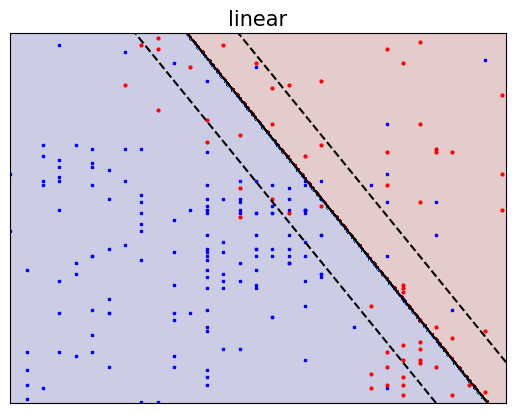

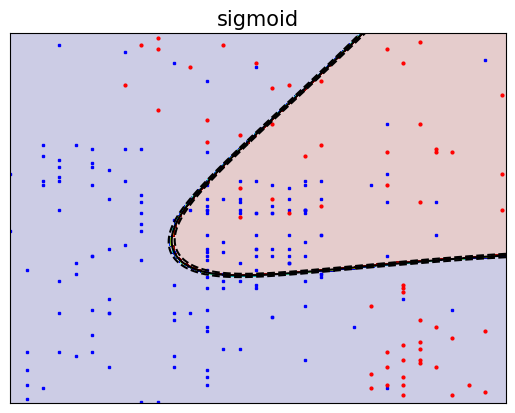

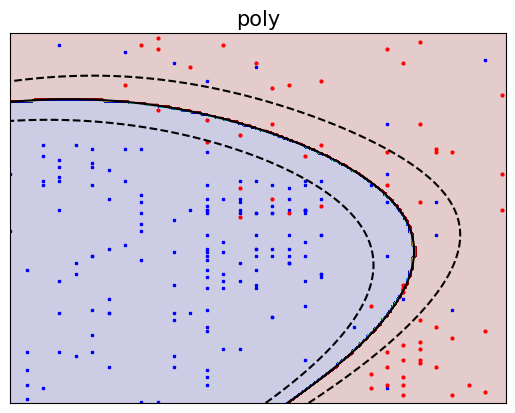

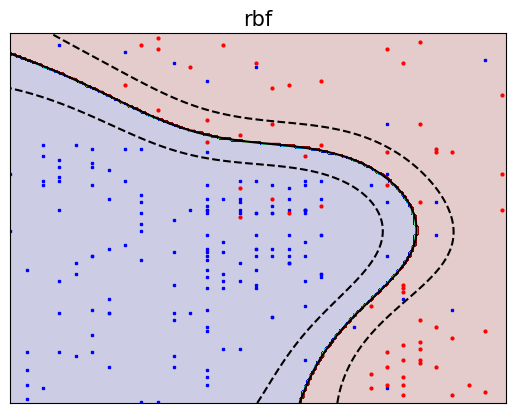

In [152]:
# train model and visualize result
def svm_model(X, Y, XTest, YTest):
    fignum = 1

    # fit the model
    for kernel in ('linear','sigmoid', 'poly', 'rbf'):
        clf = SVC(kernel=kernel, gamma=1, coef0 = 1)
        clf.fit(X, Y)
        
        # predict and evaluate
        pred = clf.predict(XTest)
        print(f'{kernel} kernel')
        print('accuracy score:', accuracy_score(YTest, pred))
        print('confusion matrix:\n', confusion_matrix(YTest, pred))

        # plot the line, the points, and the nearest vectors to the plane
        fig, ax = plt.subplots()
        plt.figure(fignum, figsize=(4, 4))
        plt.clf()

        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], 
                    s=100, facecolors='None')
        plt.plot(X[Y==0, 0], X[Y==0, 1], 'bs', markersize = 2)
        plt.plot(X[Y==1, 0], X[Y==1, 1], 'ro', markersize = 2)
        
        plt.axis('tight')
        x_min = -1.5
        x_max = 1.5
        y_min = -1.5
        y_max = 1.5
        
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
        
        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(4, 4))
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], 
                    linestyles=['--', '-', '--'], 
                    levels=[-.5, 0, .5])
        plt.title(kernel, fontsize = 15)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        
        plt.xticks(())
        plt.yticks(())
        fignum = fignum + 1
        # pdf.savefig()
    plt.show()

svm_model(XTrain, yTrain, XTest, yTest)

#### Exercise 3. Breast Cancer

load data from library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')

# breast cancer dataset for classification
data = load_breast_cancer()
print(data.feature_names)
print(data.target_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
['malignant' 'benign']


split data into training and test set

In [2]:
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.3,random_state=109)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(398, 30)
(171, 30)
(398,)
(171,)


train model and evaluate

In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

In [8]:
# fit the model
for kernel in ('linear','sigmoid','rbf'):
    clf = SVC(kernel=kernel, gamma='scale', coef0=1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print(f'{kernel} kernel')
    print('accuracy score:', accuracy_score(y_test, pred))
    print('confusion matrix:\n', confusion_matrix(y_test, pred))

linear kernel
accuracy score: 0.9649122807017544
confusion matrix:
 [[ 61   2]
 [  4 104]]
sigmoid kernel
accuracy score: 0.631578947368421
confusion matrix:
 [[  0  63]
 [  0 108]]
rbf kernel
accuracy score: 0.9239766081871345
confusion matrix:
 [[ 50  13]
 [  0 108]]


In [11]:
clf2 = SVC(kernel='poly', degree=2)
clf2.fit(X_train, y_train)
pred = clf2.predict(X_test)
print(f'poly kernel')
print('accuracy score:', accuracy_score(y_test, pred))
print('confusion matrix:\n', confusion_matrix(y_test, pred))

poly kernel
accuracy score: 0.935672514619883
confusion matrix:
 [[ 52  11]
 [  0 108]]
